In [ ]:
# El objetivo de esta tarea es:
# 1) Implementar convolucion (usando cython)
# 2) Implementar piramides de Gauss y Laplace
# 3) Implementar reconstruccion de una imagen a partir de las piramides
# 4) Graficar las piramides
#
# Nota: los arreglos (matrices) creados deben ser de tipo np.float32

time: 1.27 ms


In [ ]:
# Si se usa colaboratory, esta linea permite subir imagenes a la carpeta del notebook
from google.colab import files
uploaded = files.upload()

Saving frutas.png to frutas.png
Saving madera.png to madera.png
Saving poligonos.png to poligonos.png
Saving techo.png to techo.png


In [ ]:
# Mostrar archivos en la carpeta del notebook
!ls

frutas.png     Reconstructed_image_0.png  Reconstructed_image_3.png
madera.png     Reconstructed_image_1.png  sample_data
poligonos.png  Reconstructed_image_2.png  techo.png
time: 113 ms


In [ ]:
# Para medir tiempo de ejecucion
!pip install ipython-autotime

time: 2.13 s


In [ ]:
# Extensiones
%load_ext Cython
%load_ext autotime

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.03 ms


In [ ]:
# Paquetes a ser usados
import numpy as np
import cv2
import cython
import math
# Este paquete solo se debe usar si se usa colaboratory
from google.colab.patches import cv2_imshow

time: 4.81 ms


In [ ]:
%%cython
import cython
import numpy as np
import cv2
cimport numpy as np

# La convolucion debe ser implementada usando cython (solo esta funcion en cython)
#@cython.boundscheck(False)
cpdef float[:, :] convolution_cython(float [:, :] input, float [:, :] mask):
  cdef int r, c, k_r, k_c, rows, cols, m_rows, m_cols, border_r, border_c, conv_size, conv_position, i, j
  cdef float Sum

  # tamano de la imagen
  rows = input.shape[0]
  cols = input.shape[1]
  m_rows = mask.shape[0]
  m_cols = mask.shape[1]
  border_r = int(m_rows/(2)) # Tamaño del borde horizontal.
  border_c = int(m_cols/(2)) # Tamaño del borde vertical.
  conv_size = int(m_rows*m_cols)

  Sum = 0
  cdef np.ndarray conv_pixel=np.zeros(conv_size, dtype = np.float32)
  cdef np.ndarray output=np.zeros([rows, cols], dtype = np.float32)
  # Por hacer: implementar convolucion entre "input" y "mask"
  for r in range(border_r, rows - border_r): # Recorriendo las filas
    for c in range(border_c, cols - border_c): # Recorriendo las columnas
      conv_pixel = np.zeros(conv_size, dtype=np.float32) # Definiendo el arreglo con las convoluciones durante 
      conv_position = 0 # Recorriendo el arreglo desde el inicio.
      for k_r in range(m_rows):
        for k_c in range(m_cols):
          conv_pixel[conv_position] = input[r-border_r+k_r ,c-border_c+k_c]*mask[k_r,k_c]
          conv_position += 1
      Sum = sum(conv_pixel)
      output[r, c] = Sum
      
  # Eliminando los bordes con ceros.
  for i in range(2):
    if i == 0:
      j = 1
      while j <= border_r:
        output = np.delete(output, 0, 0)
        output = np.delete(output, -1, 0)
        j += 1 
    else:
      j = 1
      while j <= border_c:
        output = np.delete(output, 0, 1)
        output = np.delete(output, -1, 1)
        j += 1
  return output

time: 5.88 ms


In [ ]:
# Función auxiliar zero padding.

def zero_padding(input, mask):
  image = input.copy()
  rows_to_add = int(mask.shape[0]/2)
  cols_to_add = int(mask.shape[1]/2)
  zeros_rows = np.zeros(input.shape[1], dtype=np.float32)
  r = 0
  while r < rows_to_add:
    image = np.vstack([zeros_rows, image])
    image = np.vstack([image, zeros_rows])
    r += 1
  zeros_cols = np.zeros(image.shape[0], dtype=np.float32)
  c = 0
  while c < cols_to_add:
    image = np.c_[zeros_cols, image]
    image = np.c_[image, zeros_cols]
    c += 1
  return image

time: 10 ms


In [ ]:
def compute_gauss_horiz(sigma, width):
  sig = np.sqrt(sigma/2/np.log(2))
  result = np.zeros(width)
  mid = int(width/2)
  result=[(1/(sig*np.sqrt(2*np.pi)))*(1/(np.exp((i**2)/(2*sig**2)))) for i in range(-mid,mid+1)]  

  return (result/(np.sum(result))).reshape(1, width).astype(np.float32)

time: 3.34 ms


In [ ]:
def compute_gauss_vert(sigma, height):
  sig = np.sqrt(sigma/2/np.log(2))
  result = np.zeros(height)
  mid = int(width/2)
  result=[(1/(sig*np.sqrt(2*np.pi)))*(1/(np.exp((i**2)/(2*sig**2)))) for i in range(-mid,mid+1)]  

  return (result/(np.sum(result))).reshape(height, 1).astype(np.float32)

time: 4.6 ms


La función anterior se replicó usando zero padding antes de aplicar la convolución, aplicandon esta técnica los resultados mejoraron por lo que se conservo esta función para los resultados posteriores.

In [ ]:
def do_blur(input, sigma, height):
  mask_hor = compute_gauss_horiz(sigma, width=height)
  mask_ver = compute_gauss_vert(sigma, height=height)
  padding_1 = zero_padding(input, mask_hor)
  conv_hor = np.asarray(convolution_cython(padding_1, mask_hor))
  padding_2 = zero_padding(conv_hor, mask_ver)
  result = np.asarray(convolution_cython(padding_2, mask_ver))
  return result

time: 5.91 ms


In [ ]:
def subsample(input):
  result = np.copy(input)
  rows, cols = result.shape
  output = np.zeros([int(rows/2),int(cols/2)],dtype = np.float32)
  for r in range(int(rows/2)):
    for c in range(int(cols/2)):
      output[r,c] = result[int(2*r),int(2*c)]
  return output

time: 5.74 ms


In [ ]:
sigma = 2
width = 7

def compute_gauss_pyramid(input, nlevels):
  global sigma
  global width
  gausspyramid = []
  current = np.copy(input)
  gausspyramid.append(current)
  for i in range(1,nlevels):
    # Por hacer:
    # 1) Aplicar do_blur a la imagen gausspyramid[i-1], con sigma 2.0 y ancho 7
    # 2) Submuestrear la imagen resultante usando subsample y guardando el resultado en current
    current = do_blur(current, sigma=sigma, height=width)
    current = subsample(current)
    gausspyramid.append(current)
  return gausspyramid

time: 7.53 ms


In [ ]:
def show_gauss_pyramid(pyramid):
  # Por hacer: mostrar las imagenes de la piramide de gauss
  # Se recomienda usar cv2_imshow( ) para mostrar las imagenes
  len_pyramid = len(pyramid)
  for k in range(len_pyramid):
    cv2_imshow(pyramid[k])

time: 2.95 ms


In [ ]:
im_data = dict()
q_images = 4
levels = 5

im_data[0] = cv2.imread('frutas.png')[:,:,0].astype(np.float32)
im_data[1] = cv2.imread('madera.png')[:,:,0].astype(np.float32)
im_data[2] = cv2.imread('poligonos.png')[:,:,0].astype(np.float32)
im_data[3] = cv2.imread('techo.png')[:,:,0].astype(np.float32)

time: 28.8 ms


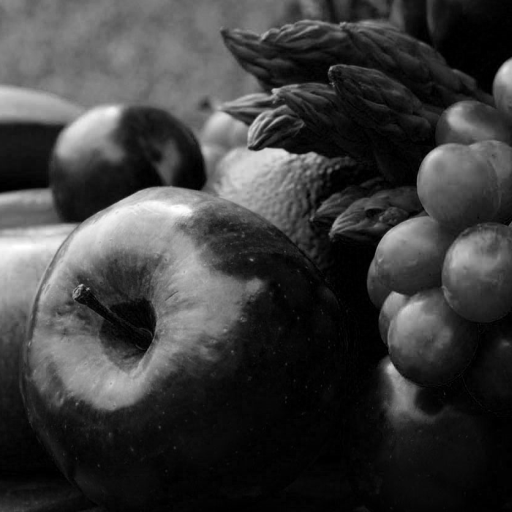

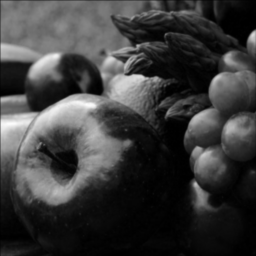

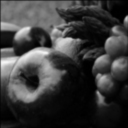

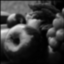

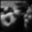

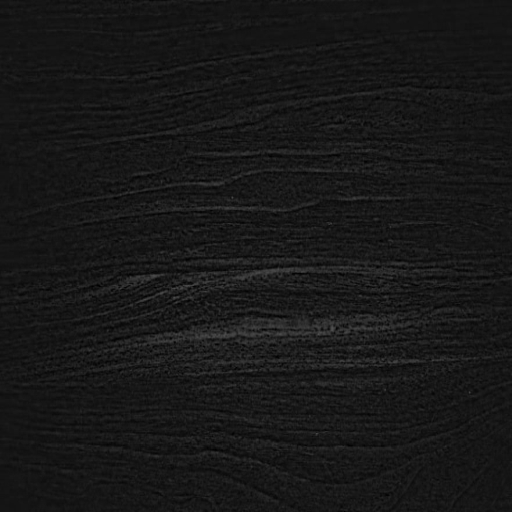

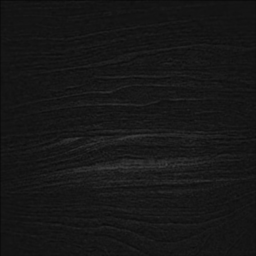

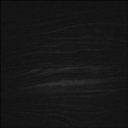

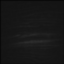

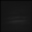

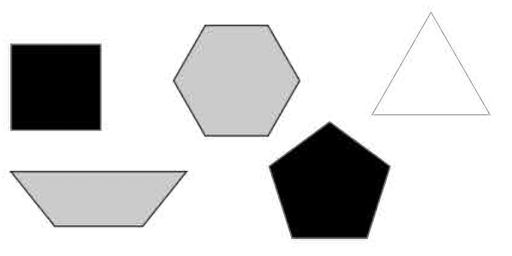

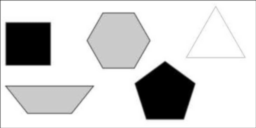

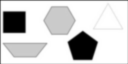

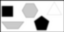

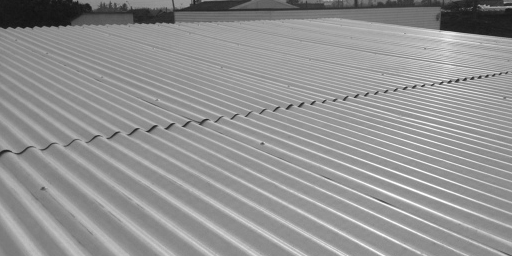

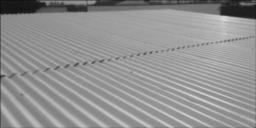

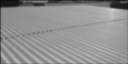

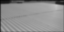

time: 13.2 s


In [ ]:
for k in range(q_images):
  gauss_pyramid_image = compute_gauss_pyramid(im_data[k], levels)
  show_gauss_pyramid(gauss_pyramid_image)

In [ ]:
def subtract(input1, input2):
  output = input1 - input2
  return output

time: 1.46 ms


In [ ]:
def add(input1, input2):
  output = input1 + input2
  return output

time: 1.82 ms


In [ ]:
def scale_abs(input, factor):
  return factor*abs(input)

time: 1.23 ms


In [ ]:
def compute_laplace_pyramid(input, nlevels):
  global sigma
  global width
  gausspyramid = []
  laplacepyramid = []
  current = np.copy(input)
  gausspyramid.append(current)
  for i in range(1, nlevels):
    # Por hacer:
    # 1) Aplicar do_blur( ) a la imagen gausspyramid[i-1], con sigma 2.0 y ancho 7
    # 2) Guardar en laplacepiramid el resultado de restar gausspyramid[i - 1] y la imagen calculada en (1)
    current_conv = do_blur(current, sigma, height=width)
    current_diff = subtract(current, current_conv)
    laplacepyramid.append(current_diff)  # Esta linea se debe reemplazar por lo indicado en (2)
    current = subsample(current_conv)
    # 3) Submuestrear la imagen calculada en (1), guardar el resultado en current
    gausspyramid.append(current)
  laplacepyramid.append(current)  # Se agrega el ultimo piso de la piramide de Laplace
  return laplacepyramid

time: 10.3 ms


In [ ]:
laplace_test = compute_laplace_pyramid(im_data[0], 5)

time: 4.46 s


In [ ]:
def show_laplace_pyramid(pyramid):
  len_pyramid = len(pyramid)
  factor = 5
  for k in range(len_pyramid):
    if k == len_pyramid -1:
      cv2_imshow(pyramid[k])
    else:
      level_show = scale_abs(pyramid[k], factor)
      cv2_imshow(level_show)

time: 3.89 ms


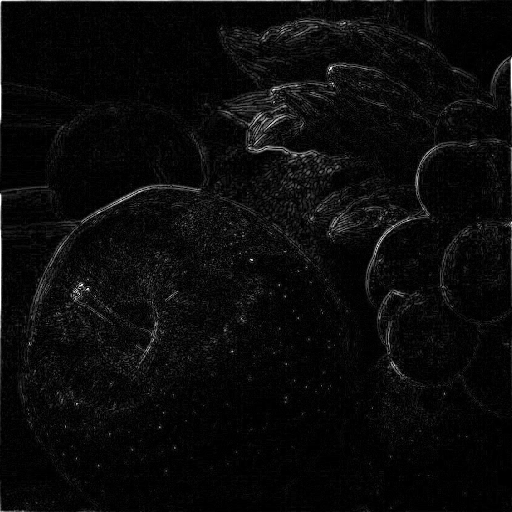

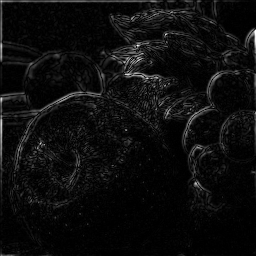

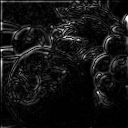

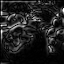

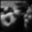

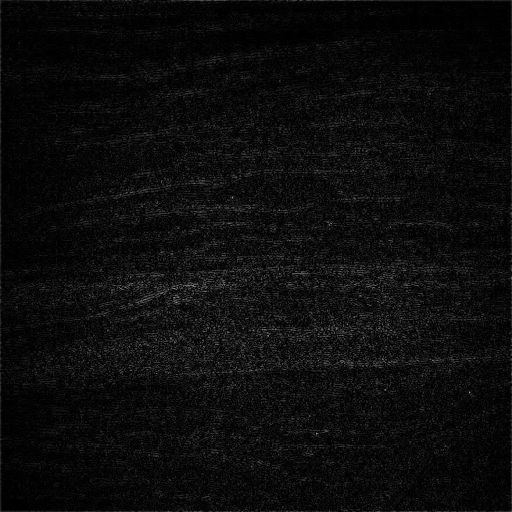

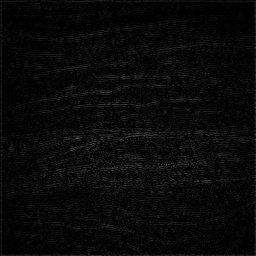

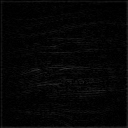

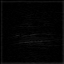

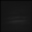

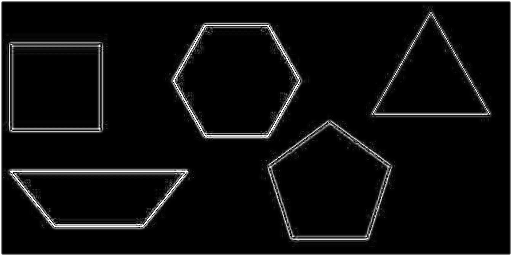

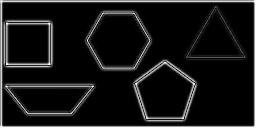

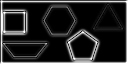

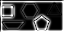

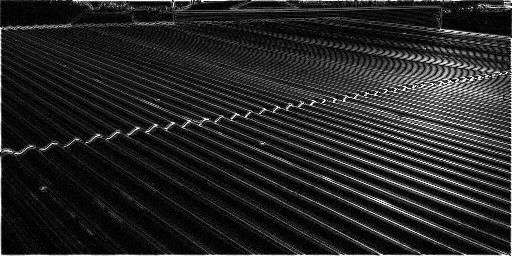

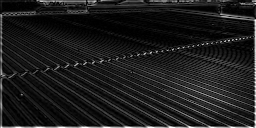

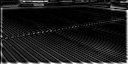

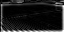

time: 13.2 s


In [ ]:
for k in range(q_images):
  laplace_pyramid = compute_laplace_pyramid(im_data[k], 5)
  show_laplace_pyramid(laplace_pyramid)

In [ ]:
def upsample(input):
  # Por hacer: implementar duplicacion del tamaño de imagen pixel a pixel
  # Un pixel de la imagen de salida debe ser el promedio de los 4 pixeles mas cercanos de la imagen de entrada
  # Se debe tener cuidado de que los indices no salgan fuera del tamano de la imagen
  output = np.copy(input) #Esto se debe eliminar
  output_final = np.zeros(2*np.array(input.shape), dtype=np.float32)
  rows = input.shape[0]
  cols = input.shape[1]
  # Expandiendo la imagen como un tablero de ajedrez de forma horizontal.
  output_1 = np.zeros([rows, 2*cols], dtype=np.float32)
  zeros_row = np.zeros(cols, dtype=np.float32)
  for r in range(rows):
    len_row = len(input[r])
    if r%2 == 0:
      output_1[r] = np.insert(input[r], range(1,len_row+1), zeros_row)
    elif r%2 == 1:
      output_1[r] = np.insert(input[r], range(len_row), zeros_row)
    else:
      continue
  # Calculo de los pixeles añadidos con el promedio de sus vecinos.
  rows_1 = output_1.shape[0]
  cols_1 = output_1.shape[1]
  for r in range(rows_1):
    if r%2 == 0:
      for c in range(1, cols_1,2):
        if r == 0: # En caso de que se este haciendo el cálculo de los pixeles añadidos en la primera fila.
          if c == (cols_1-1): # En caso de que se este procesando el último pixel de la primera fila
            output_1[r,c] = np.mean([output_1[r,c-1], output_1[r+1,c]])
          else: # En caso de que no se encuentre en la esquina
            output_1[r,c] = np.mean([output_1[r,c-1], output_1[r+1,c], output_1[r,c+1]])
        elif r == rows_1 - 1: # En caso de que la última fila sea par.
          if c == (cols_1-1):
            output_1[r,c] = np.mean([output_1[r,c-1], output_1[r-1,c]])
          else: # En caso de que no este en una esquina
            output_1[r,c] = np.mean([output_1[r,c-1], output_1[r-1,c], output_1[r, c+1]])
        else: # En caso de que no este en los bordes
          if c == (cols_1-1): # En caso de que se encuentre al final de cada fila.
            output_1[r,c] = np.mean([output_1[r, c-1],output_1[r-1, c], output_1[r+1, c]])
          else: # En caso de que no encuentre al final de la fila
            output_1[r,c] = np.mean([output_1[r, c-1],output_1[r-1, c], output_1[r+1, c], output_1[r, c+1]])

    elif r%2 == 1: # Si la fila es impar
      for c in range(0, cols_1,2):
        if r == rows_1 - 1: # En caso de que la última fila sea par.
          if c == 0:
            output_1[r,c] = np.mean([output_1[r-1,c], output_1[r,c+1]])
          else: # En caso de que no este en una esquina
            output_1[r,c] = np.mean([output_1[r,c-1], output_1[r-1,c], output_1[r, c+1]])
        else: # En caso de que no este en los bordes
          if c == 0: # En caso de que se encuentre al final de cada fila.
            output_1[r,c] = np.mean([output_1[r-1, c],output_1[r, c+1], output_1[r+1, c]])
          else: # En caso de que no encuentre al final de la fila
            output_1[r,c] = np.mean([output_1[r, c-1],output_1[r-1, c], output_1[r+1, c], output_1[r, c+1]])

  # Expandiendo la imagen como un tablero de ajedrez de forma vertical.
  rows_1 = output_1.shape[0]
  cols_1 = output_1.shape[1]
  zero_cols = np.zeros(rows_1, dtype=np.float32)
  output_final = np.zeros([2*rows_1, cols_1], dtype=np.float32)
  for c in range(cols_1):
    if c%2 == 0:
      output_final[:,c] = np.insert(output_1[:,c], range(1, rows_1+1), zero_cols)
    elif c%2 == 1:
      output_final[:,c] = np.insert(output_1[:,c], range(0, rows_1), zero_cols)
    else:
      continue

  # Calculando los pixeles añadidos como el promedio de sus vecinos, (proceso análogo al anterior).

  rows_1 = output_final.shape[0]
  cols_1 = output_final.shape[1]
  for r in range(rows_1):
    if r%2 == 0:
      for c in range(1, cols_1,2):
        if r == 0: # En caso de que se este haciendo el cálculo de los pixeles añadidos en la primera fila.
          if c == (cols_1-1): # En caso de que se este procesando el último pixel de la primera fila
            output_final[r,c] = np.mean([output_final[r,c-1], output_final[r+1,c]])
          else: # En caso de que no se encuentre en la esquina
            output_final[r,c] = np.mean([output_final[r,c-1], output_final[r+1,c], output_final[r,c+1]])
        elif r == rows_1 - 1: # En caso de que la última fila sea par.
          if c == (cols_1-1):
            output_final[r,c] = np.mean([output_final[r,c-1], output_final[r-1,c]])
          else: # En caso de que no este en una esquina
            output_final[r,c] = np.mean([output_final[r,c-1], output_final[r-1,c], output_final[r, c+1]])
        else: # En caso de que no este en los bordes
          if c == (cols_1-1): # En caso de que se encuentre al final de cada fila.
            output_final[r,c] = np.mean([output_final[r, c-1],output_final[r-1, c], output_final[r+1, c]])
          else: # En caso de que no encuentre al final de la fila
            output_final[r,c] = np.mean([output_final[r, c-1],output_final[r-1, c], output_final[r+1, c], output_final[r, c+1]])

    elif r%2 == 1: # Si la fila es impar
      for c in range(0, cols_1,2):
        if r == rows_1 - 1: # En caso de que la última fila sea par.
          if c == 0:
            output_final[r,c] = np.mean([output_final[r-1,c], output_final[r,c+1]])
          else: # En caso de que no este en una esquina
            output_final[r,c] = np.mean([output_final[r,c-1], output_final[r-1,c], output_final[r, c+1]])
        else: # En caso de que no este en los bordes
          if c == 0: # En caso de que se encuentre al final de cada fila.
            output_final[r,c] = np.mean([output_final[r-1, c],output_final[r, c+1], output_final[r+1, c]])
          else: # En caso de que no encuentre al final de la fila
            output_final[r,c] = np.mean([output_final[r, c-1],output_final[r-1, c], output_final[r+1, c], output_final[r, c+1]])
  return output_final


time: 141 ms


In [ ]:
def reconstruct(laplacepyramid):
  output = np.copy( laplacepyramid[len(laplacepyramid)-1] )
  for i in range(1, len(laplacepyramid)):
    lev = int(len(laplacepyramid)) - i - 1
    # Por hacer: repetir estos dos pasos:
    # (1) Duplicar tamano output usando upsample( )
    # (2) Sumar resultado de (1) y laplacepyramid[lev] usando add( ), almacenar en output
    up_image = upsample(output)
    output = add(up_image, laplacepyramid[lev])
  return output

time: 4.69 ms


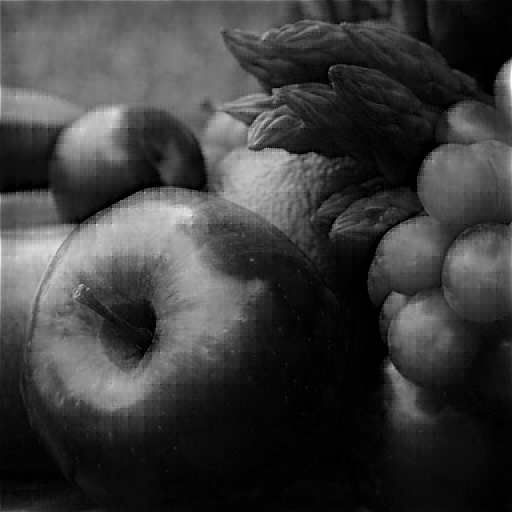

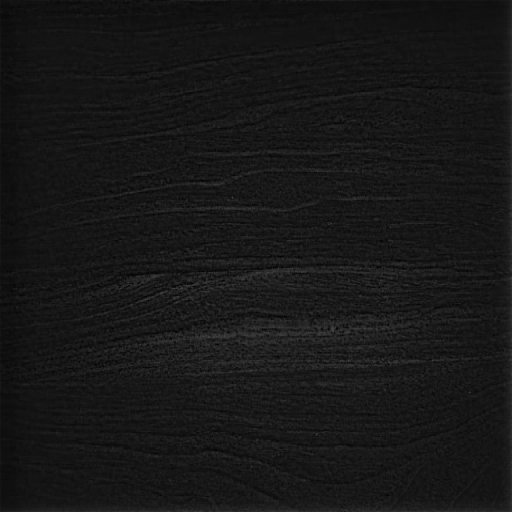

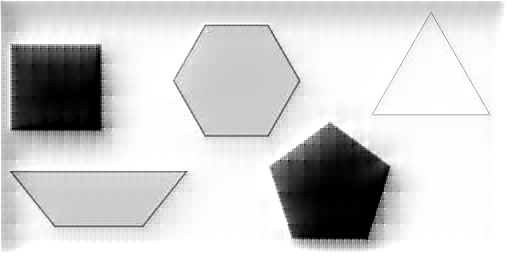

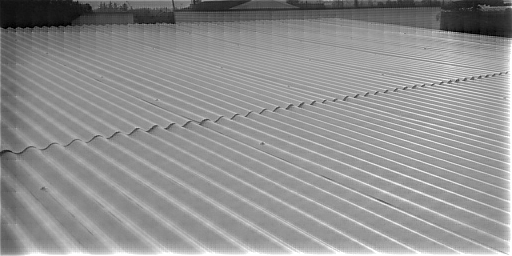

time: 23.8 s


In [ ]:
for k in range(q_images):
  laplace_test = compute_laplace_pyramid(im_data[k], 5)
  result = reconstruct(laplace_test)
  cv2_imshow(result)

Piramide de gauss:


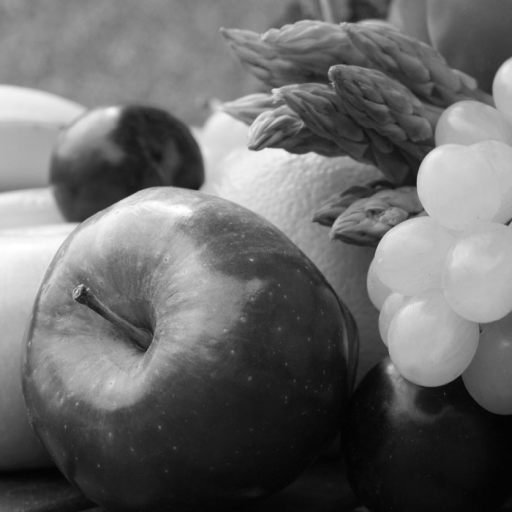

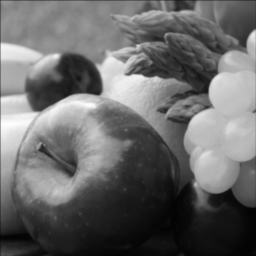

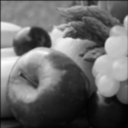

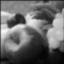

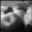

Piramide de laplace:


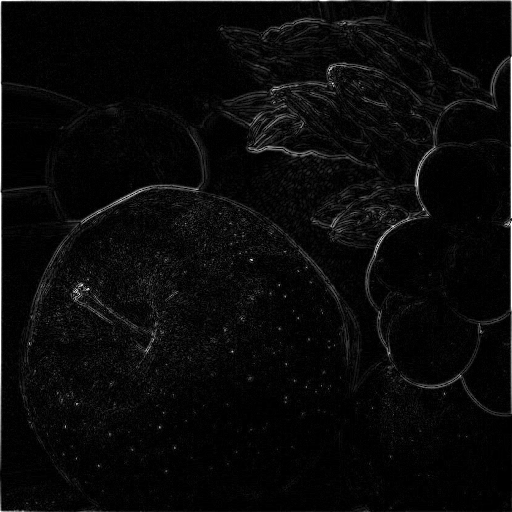

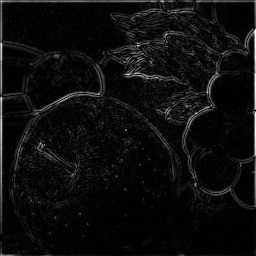

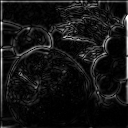

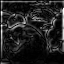

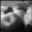

reconstruida:


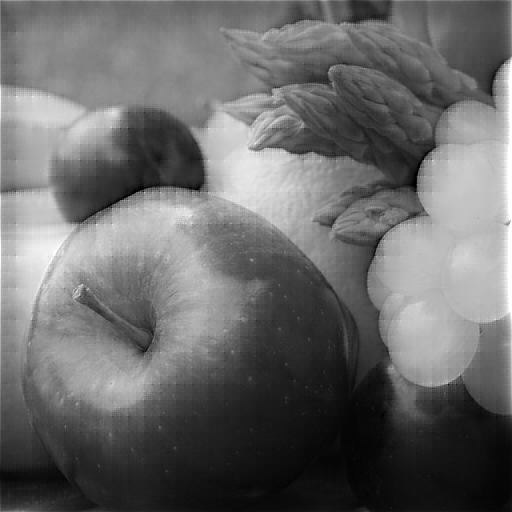

time: 12.5 s


In [ ]:
originalRGB = cv2.imread('frutas.png') #Leer imagen
# originalRGB = cv2.imread('madera.png') #Leer imagen
# originalRGB = cv2.imread('poligonos.png') #Leer imagen
# originalRGB = cv2.imread('techo.png') #Leer imagen

if originalRGB is None:
  assert False, 'Imagen no encontrada'

if len(originalRGB.shape) == 3:
  original = cv2.cvtColor(originalRGB, cv2.COLOR_BGR2GRAY)
else:
  original = originalRGB

input = np.float32( original )

print('Piramide de gauss:')
gausspyramid = compute_gauss_pyramid(input, 5)
show_gauss_pyramid(gausspyramid)

print('Piramide de laplace:')
laplacepyramid = compute_laplace_pyramid(input, 5)
show_laplace_pyramid(laplacepyramid)

print('reconstruida:')
reconstr = reconstruct(laplacepyramid)
cv2_imshow(reconstr)

Piramide de gauss:


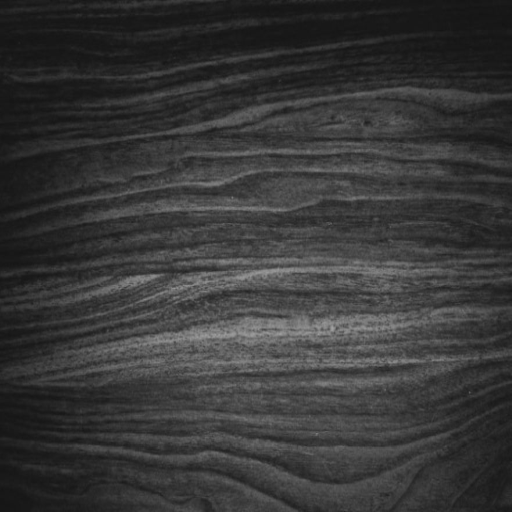

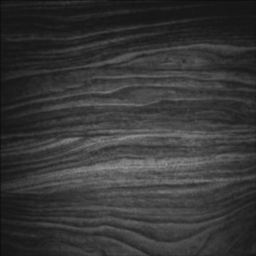

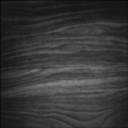

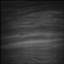

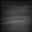

Piramide de laplace:


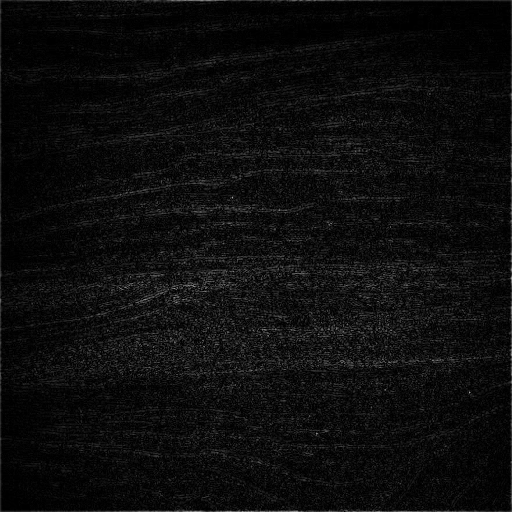

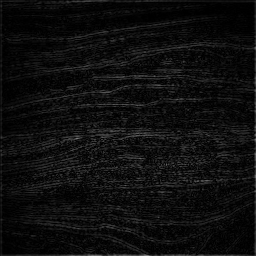

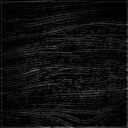

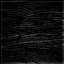

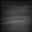

reconstruida:


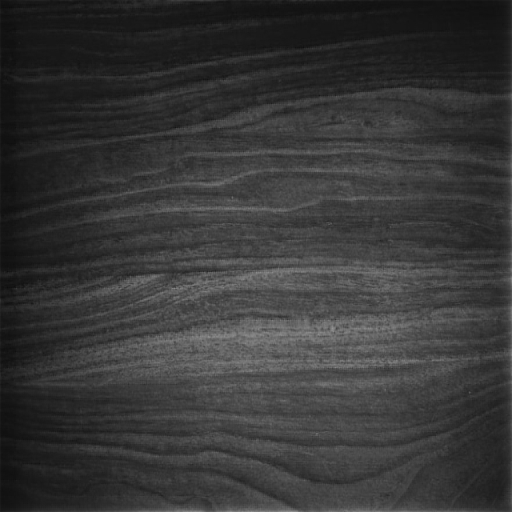

time: 12.5 s


In [ ]:
#originalRGB = cv2.imread('frutas.png') #Leer imagen
originalRGB = cv2.imread('madera.png') #Leer imagen
#originalRGB = cv2.imread('poligonos.png') #Leer imagen
#originalRGB = cv2.imread('techo.png') #Leer imagen

if originalRGB is None:
  assert False, 'Imagen no encontrada'

if len(originalRGB.shape) == 3:
  original = cv2.cvtColor(originalRGB, cv2.COLOR_BGR2GRAY)
else:
  original = originalRGB

input = np.float32( original )

print('Piramide de gauss:')
gausspyramid = compute_gauss_pyramid(input, 5)
show_gauss_pyramid(gausspyramid)

print('Piramide de laplace:')
laplacepyramid = compute_laplace_pyramid(input, 5)
show_laplace_pyramid(laplacepyramid)

print('reconstruida:')
reconstr = reconstruct(laplacepyramid)
cv2_imshow(reconstr)